Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 71}
Model Accuracy: 98.49%
Classification Report:
              precision    recall  f1-score   support

       Risky       0.99      0.97      0.98       993
    Moderate       0.99      0.99      0.99      2738
        Good       0.93      0.95      0.94       316
   Excellent       0.99      0.98      0.99       517

    accuracy                           0.98      4564
   macro avg       0.98      0.97      0.98      4564
weighted avg       0.99      0.98      0.98      4564

Model saved to ../models\driving_data_model.pkl


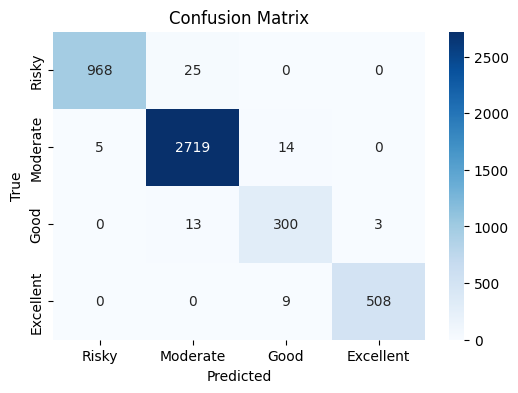

C:\Users\anush\AppData\Local\Temp\ipykernel_21492\3255960916.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


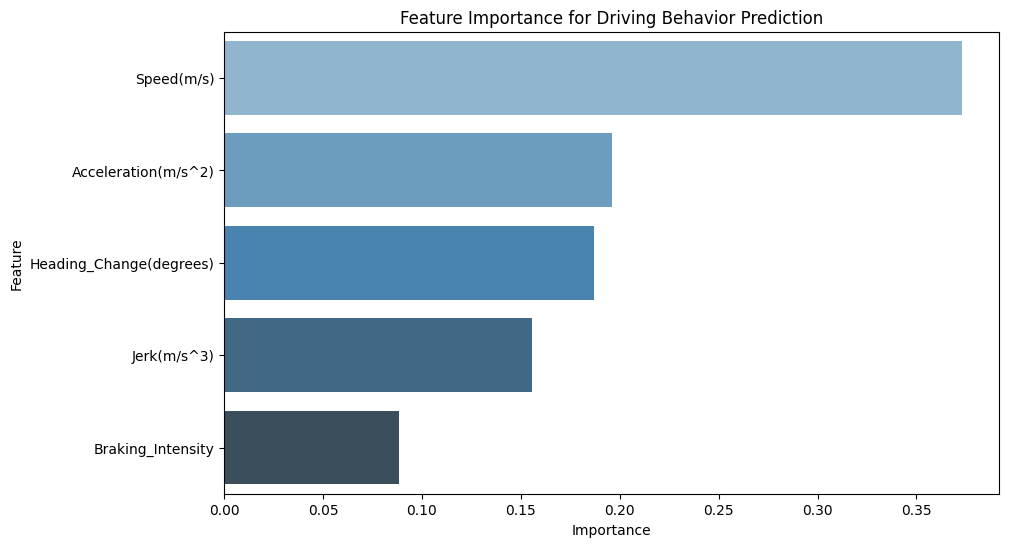

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import randint

# Load the processed data
df = pd.read_csv('../data/processed_data.csv')

# Feature Selection: Using relevant features for ML training
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity']]
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Good': 2, 'Excellent': 3})  # Convert driving categories to numeric labels

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the directory to save the model and scaler
model_directory = '../models'  # Adjust the path as needed
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the scaler for future use
scaler_path = os.path.join(model_directory, 'scaler.pkl')
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# RandomizedSearchCV for faster hyperparameter tuning with reduced parameters
param_dist = {
    'n_estimators': randint(50, 100),  # Reduced from 100-300 to 50-100
    'max_depth': [10, None],  # Reduced depth values for simpler trees
    'min_samples_split': randint(2, 6),  # Narrower range
    'min_samples_leaf': randint(1, 3)  # Narrower range
}

# Reduced the number of iterations
model = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=5, cv=3, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Get the best parameters from the RandomizedSearch
print(f"Best parameters found: {model.best_params_}")

# Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Good', 'Excellent']))

# Save the trained model to a file
model_filename = os.path.join(model_directory, 'driving_data_model.pkl')
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved to {model_filename}")

### Visualization ###

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Risky', 'Moderate', 'Good', 'Excellent'],
            yticklabels=['Risky', 'Moderate', 'Good', 'Excellent'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance Plot
feature_importances = model.best_estimator_.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Feature Importance for Driving Behavior Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
